In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/filipe/Documents/education/mlops-zoomcamp/02-experiment-tracking/theory/mlruns/1', creation_time=1684861233574, experiment_id='1', last_update_time=1684861233574, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:
df = pd.read_parquet('../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

/tmp/ipykernel_15867/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_15867/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


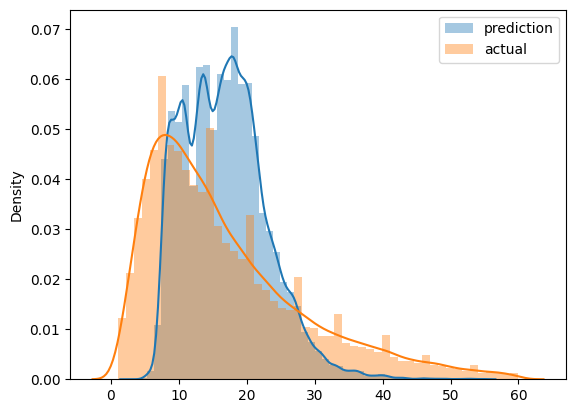

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag("developer", "filipe")

    mlflow.log_param("train-data-path", '../data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", '../data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

# Optimizing XGBoost with hyperopt

In [18]:
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope

## Defining objective function
First, let's define the train and validation DMatrices.

In [19]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

## Defining search space

The search space is composed of the possible values for the hyperparameters of XGBoost. We are going to optimize the following parameters:

In [21]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3) , exp(0) ~ [0.05 , 1]
    "reg_alpha": hp.loguniform("reg_alpha", -5, 1), # exp(-5) , exp(1) ~ [0.0067 , 2.7]
    "reg_lambda": hp.loguniform("reg_lambda", -6, 1), # exp(-6) , exp(1) ~ [0.0025 , 2.7]
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3), # exp(-1) , exp(3) ~ [0.37 , 20]
    "objective": "reg:linear",
    "seed": 42,
}

## Passing information to fmin optimization method
After defining the objective function and the search space, now we need to pass all this information to the fmin method of hyperopt. This method will try different combinations of hyperparameters and return the best one. 

In [23]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials(),
)

[16:23:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.26102                          
[1]	validation-rmse:19.38274                          
[2]	validation-rmse:18.55547                          
[3]	validation-rmse:17.77649                          
[4]	validation-rmse:17.04249                          
[5]	validation-rmse:16.35246                          
[6]	validation-rmse:15.70398                          
[7]	validation-rmse:15.09451                          
[8]	validation-rmse:14.52278                          
[9]	validation-rmse:13.98589                          
[10]	validation-rmse:13.48247                         
[11]	validation-rmse:13.01073                         
[12]	validation-rmse:12.56912                         
[13]	validation-rmse:12.15656                         
[14]	validation-rmse:11.77053                         
[15]	validation-rmse:11.41052                         
[

## Training the model with the best hyperparameters
Finally, we can train the model with the best hyperparameters and evaluate it on the test set.

In [22]:
params = {
    'learning_rate': 0.9754481890538557,
    'max_depth': 38,
    'min_child_weight': 18.323060368414655,
    'objective': 'reg:linear',
    'reg_alpha': 1.1552295470829463,
    'reg_lambda': 2.4793262827776834,
    'seed': 42,
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50,
)

2023/05/25 10:51:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '22ee624c9efb47398d58863567575062', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:51:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.86166
[1]	validation-rmse:6.72801
[2]	validation-rmse:6.70006
[3]	validation-rmse:6.68904
[4]	validation-rmse:6.67953
[5]	validation-rmse:6.68855
[6]	validation-rmse:6.68578
[7]	validation-rmse:6.67957
[8]	validation-rmse:6.67584
[9]	validation-rmse:6.67605
[10]	validation-rmse:6.67481
[11]	validation-rmse:6.67356
[12]	validation-rmse:6.67226
[13]	validation-rmse:6.67307
[14]	validation-rmse:6.67063
[15]	validation-rmse:6.67321
[16]	validation-rmse:6.67238
[17]	validation-rmse:6.67162
[18]	validation-rmse:6.67170
[19]	validation-rmse:6.67309
[20]	validation-rmse:6.67416
[21]	validation-rmse:6.67855
[22]	validation-rmse:6.67873
[23]	validation-rmse:6.67960
[24]	validation-rmse:6.67844
[25]	validation-rmse:6.67832
[26]	validation-rmse:6.67810
[27]	validation-rmse:6.67777
[28]	validation-rmse:6.67770
[29]	validation-rmse:6.67735
[30]	validation-rmse:

2023/05/25 10:52:15 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
